<a href="https://colab.research.google.com/github/Jeongmin0658/kentech_EF_CCP/blob/main/Contributors/Seongwon/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
import os
import numpy as np
import random
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms
from torchvision.utils import save_image

In [165]:
image_path = './drive/MyDrive/DLA_Datas/img_data'
test_path = './drive/MyDrive/DLA_Datas/test_data'
result_image_path = './drive/MyDrive/DLA_Datas/result_img'
channels = 1                    # MNIST has only 1

n_epochs = 30
batch_size = 128
lr = 1e-3
b1 = 0.5
b2 = 0.999

img_size = 200
hidden_dim = 400
latent_dim = 10

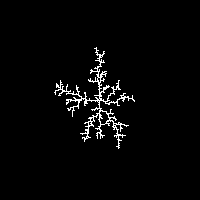

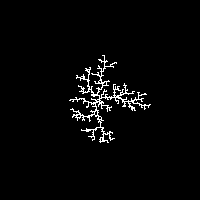

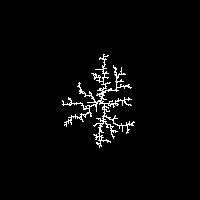

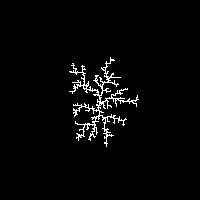

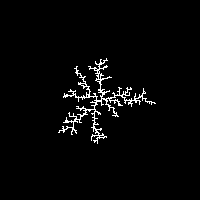

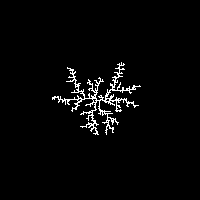

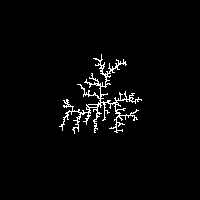

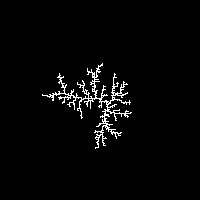

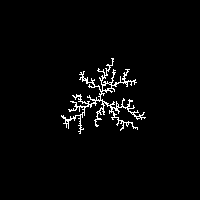

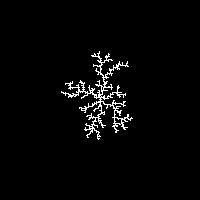

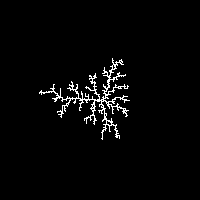

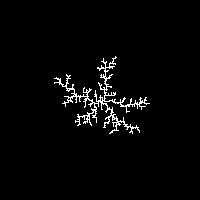

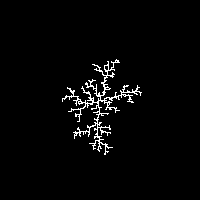

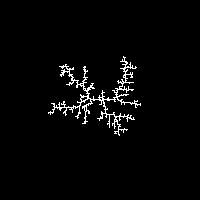

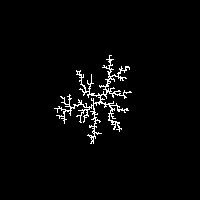

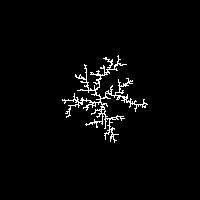

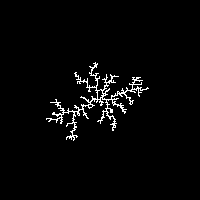

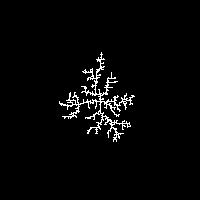

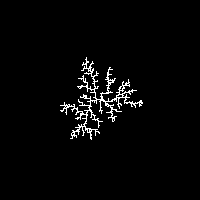

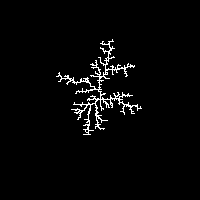

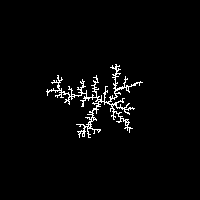

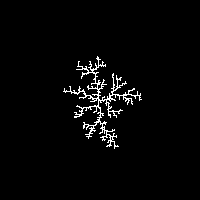

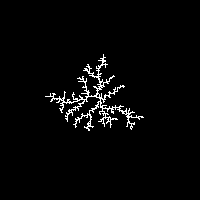

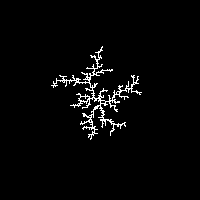

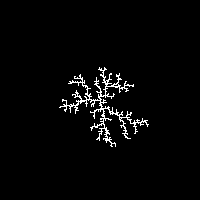

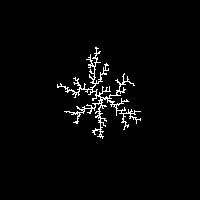

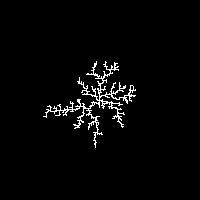

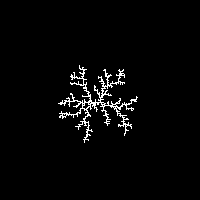

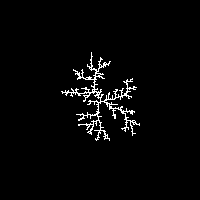

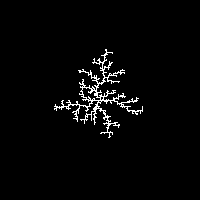

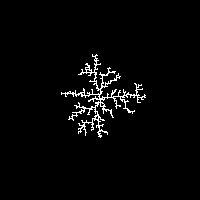

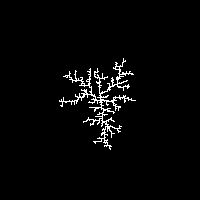

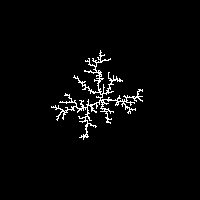

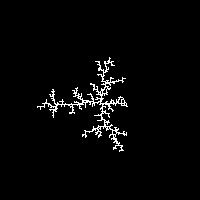

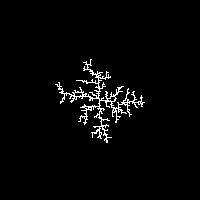

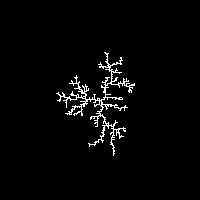

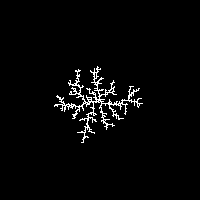

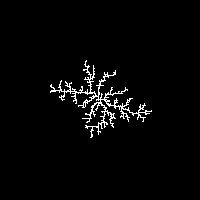

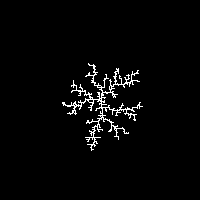

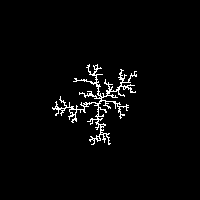

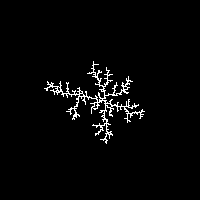

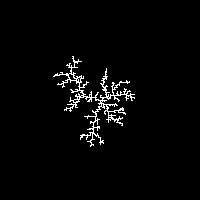

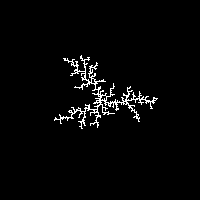

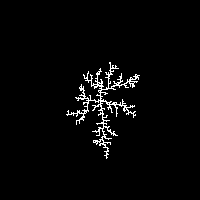

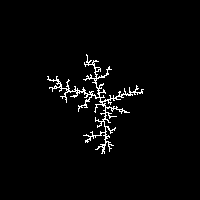

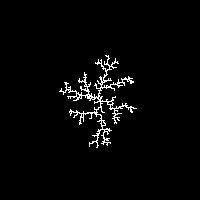

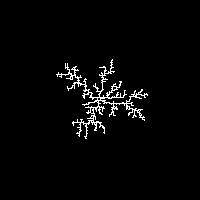

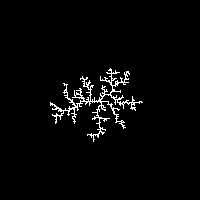

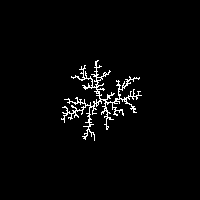

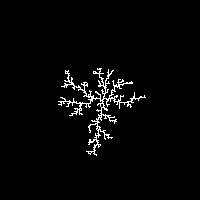

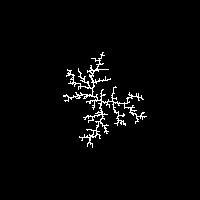

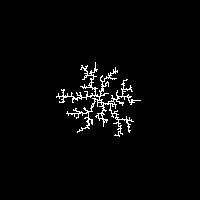

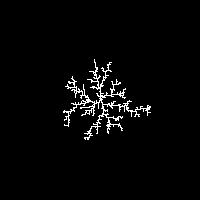

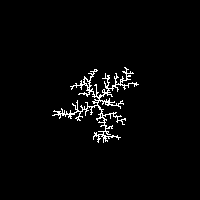

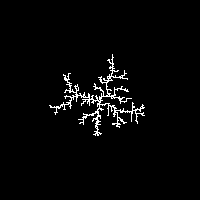

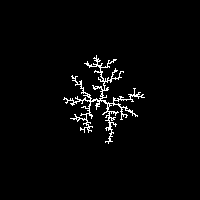

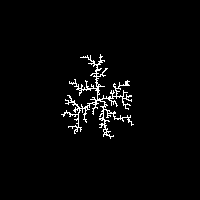

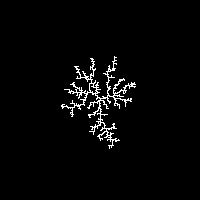

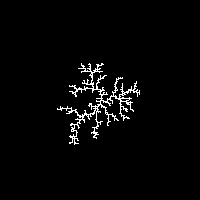

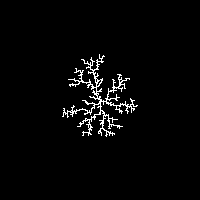

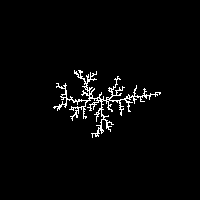

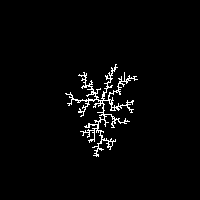

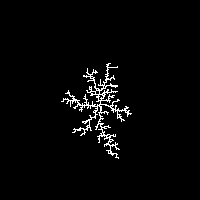

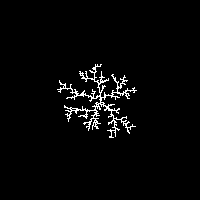

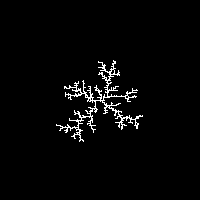

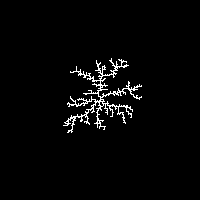

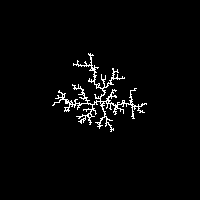

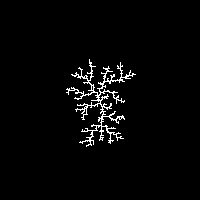

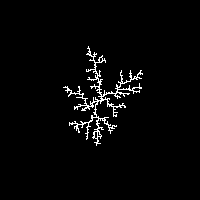

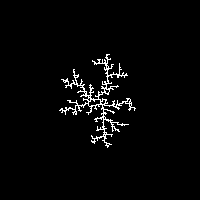

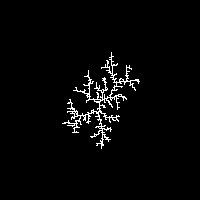

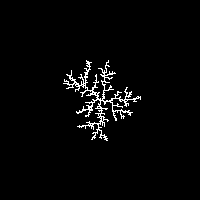

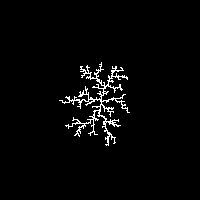

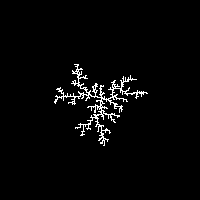

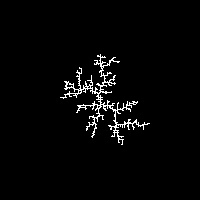

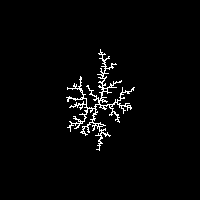

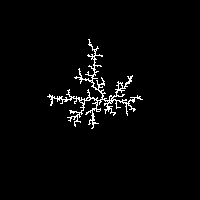

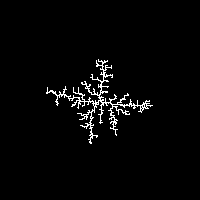

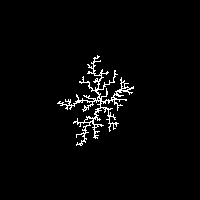

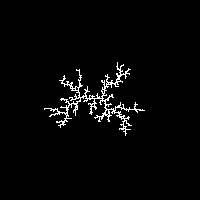

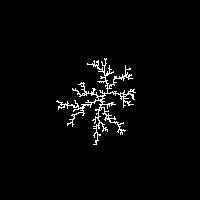

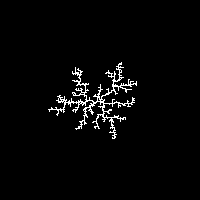

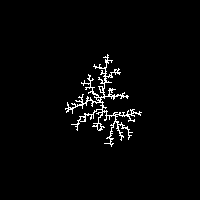

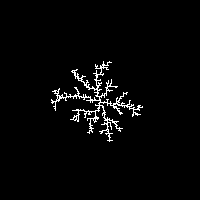

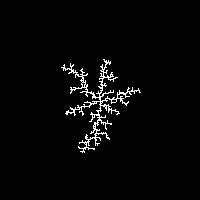

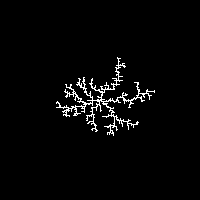

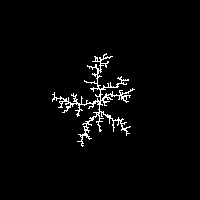

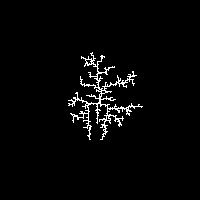

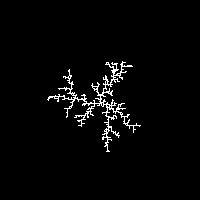

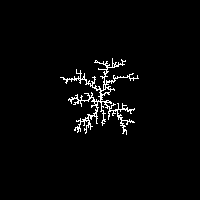

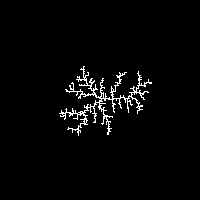

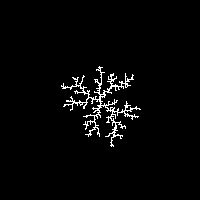

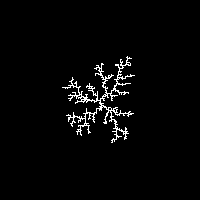

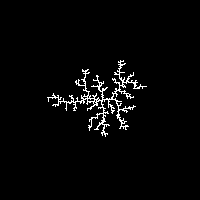

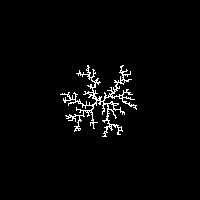

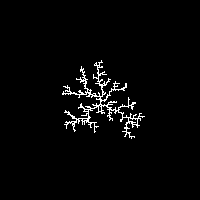

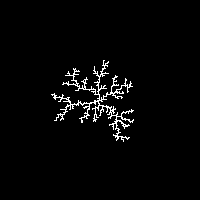

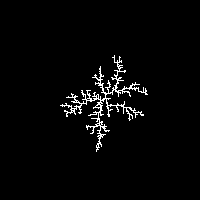

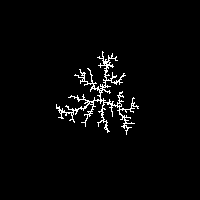

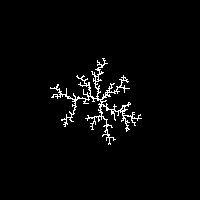

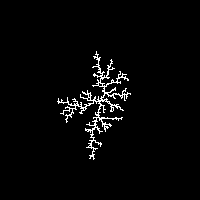

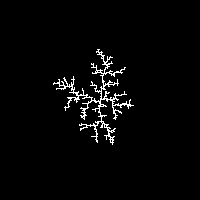

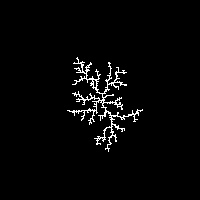

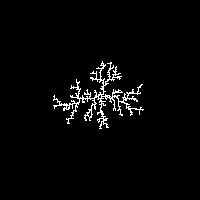

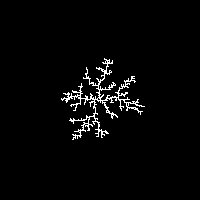

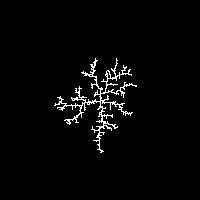

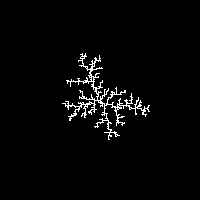

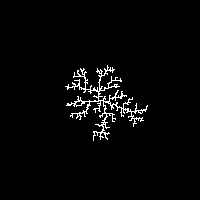

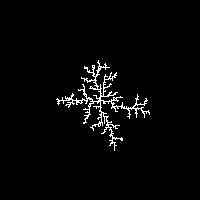

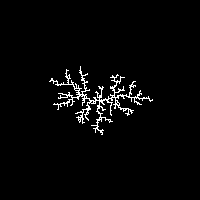

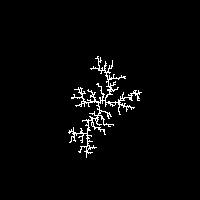

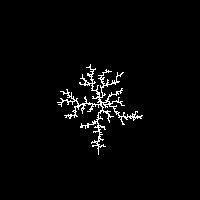

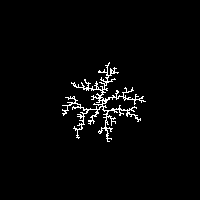

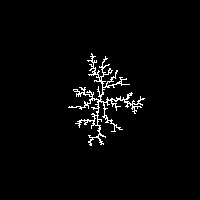

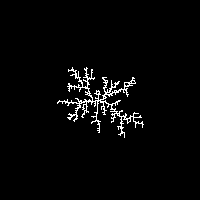

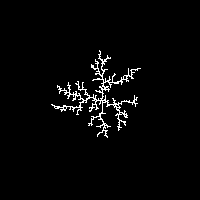

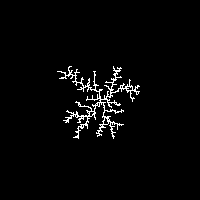

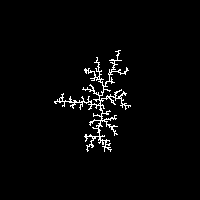

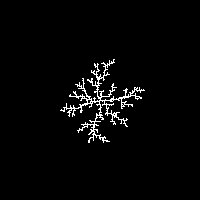

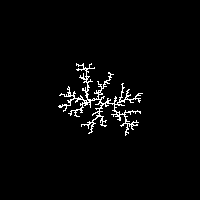

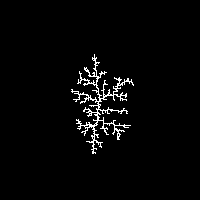

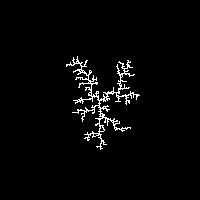

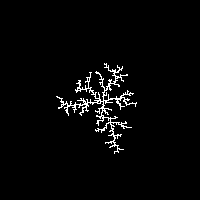

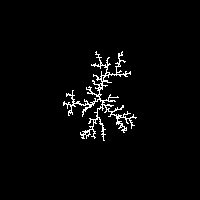

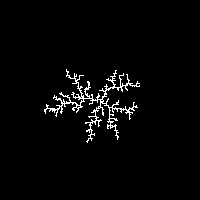

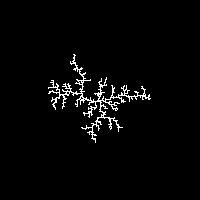

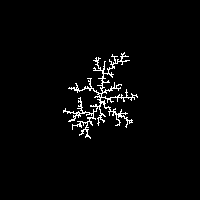

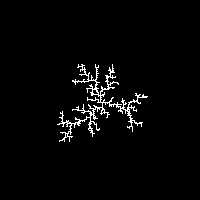

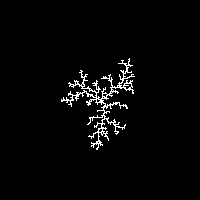

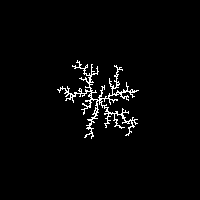

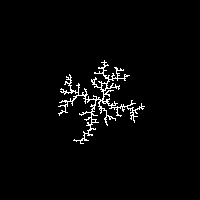

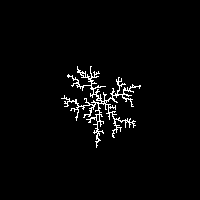

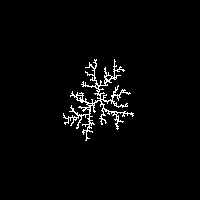

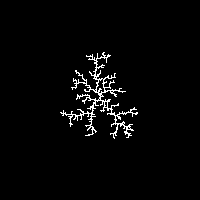

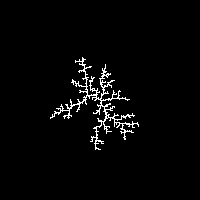

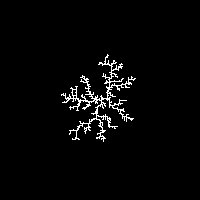

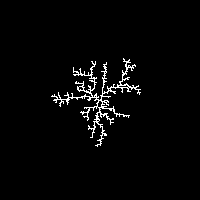

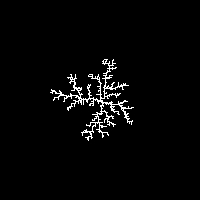

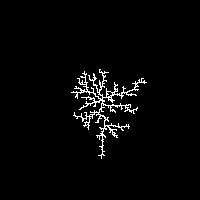

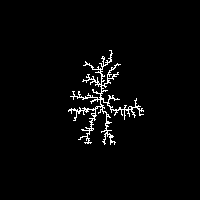

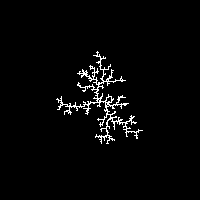

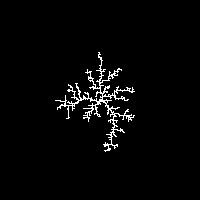

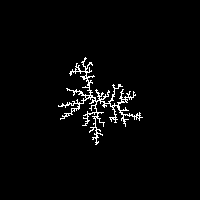

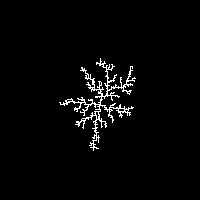

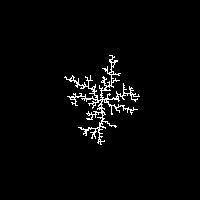

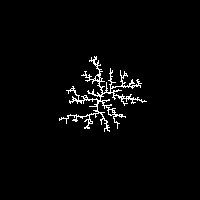

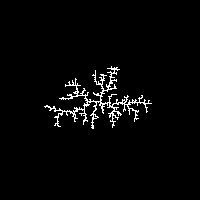

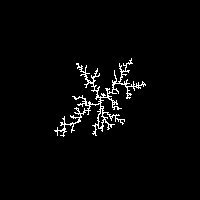

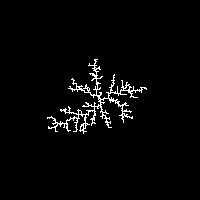

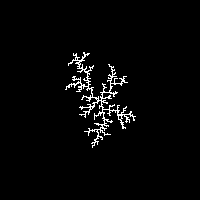

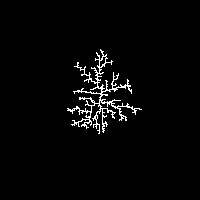

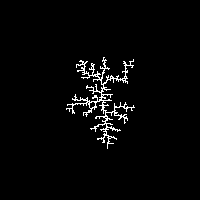

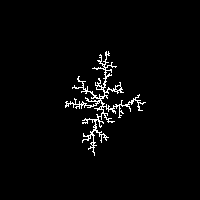

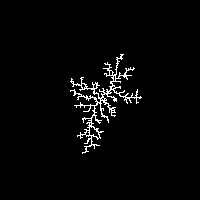

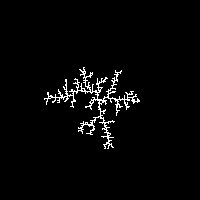

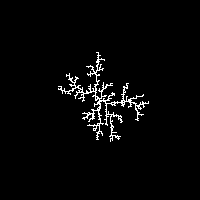

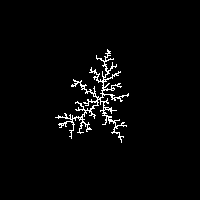

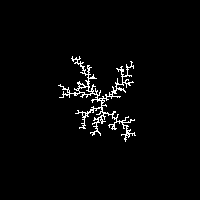

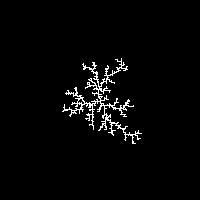

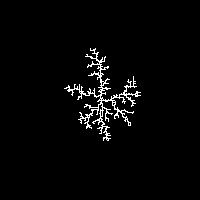

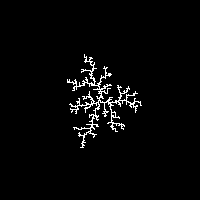

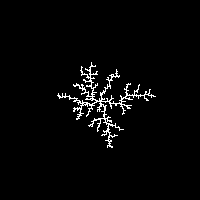

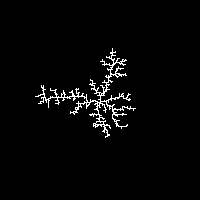

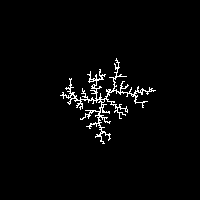

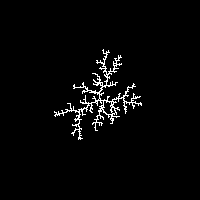

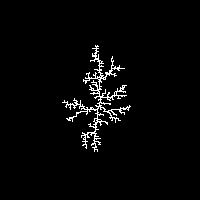

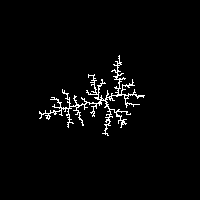

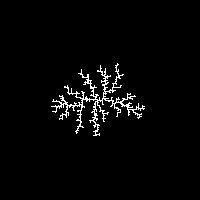

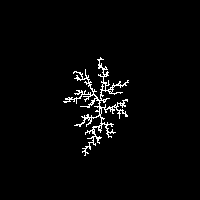

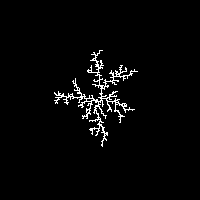

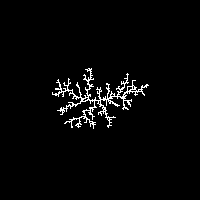

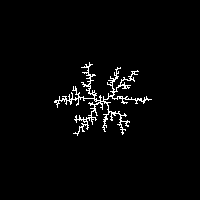

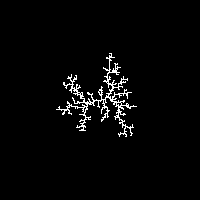

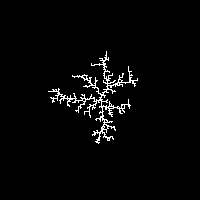

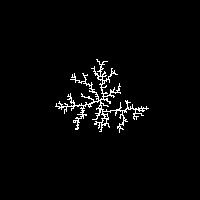

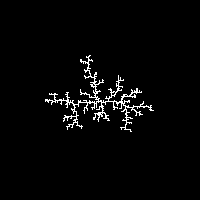

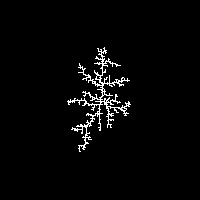

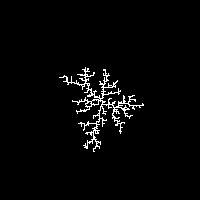

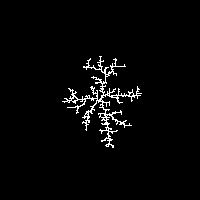

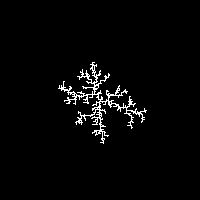

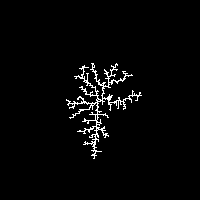

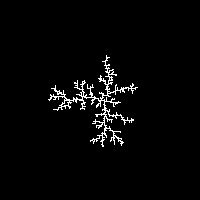

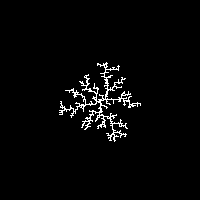

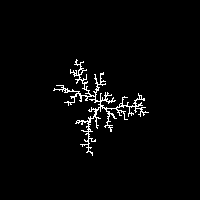

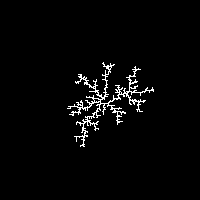

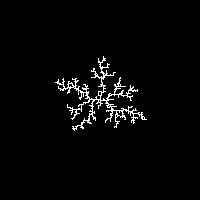

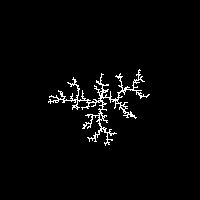

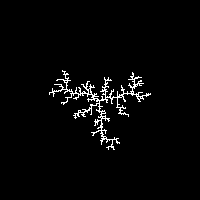

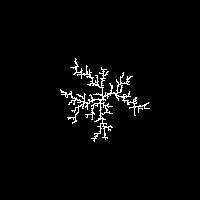

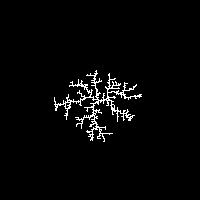

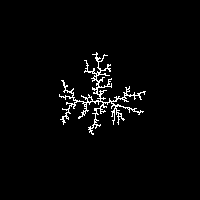

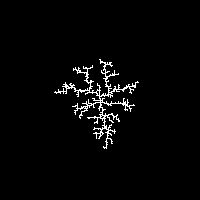

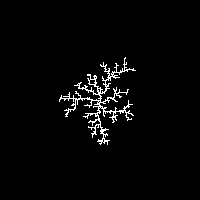

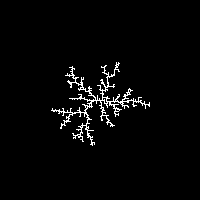

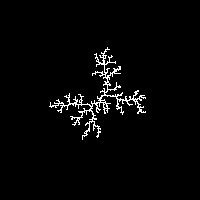

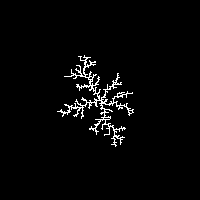

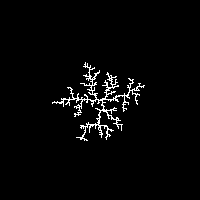

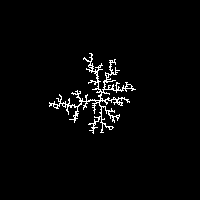

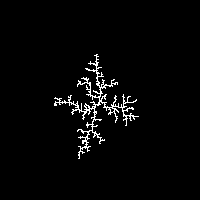

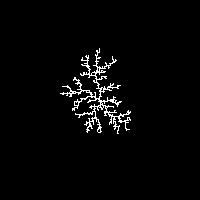

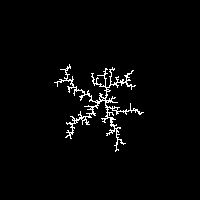

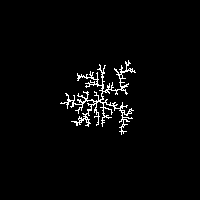

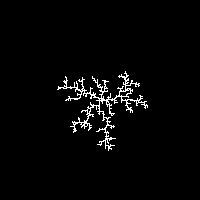

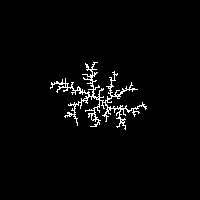

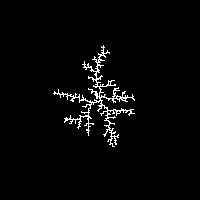

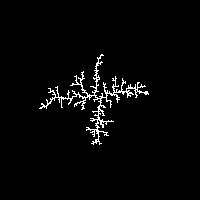

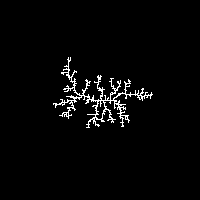

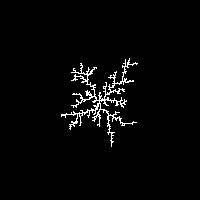

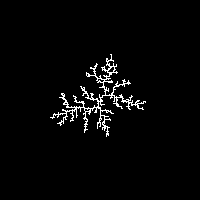

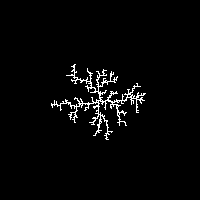

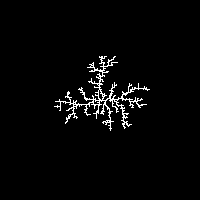

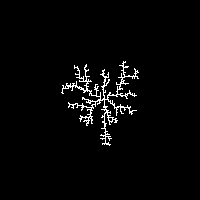

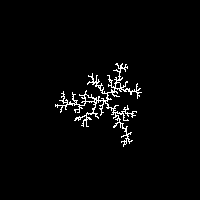

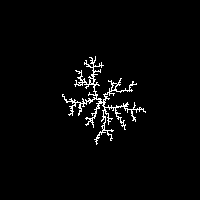

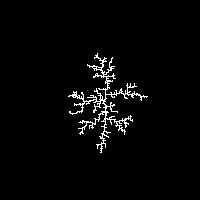

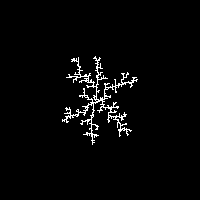

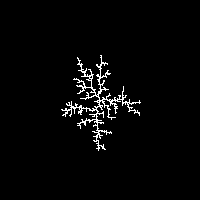

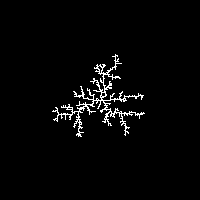

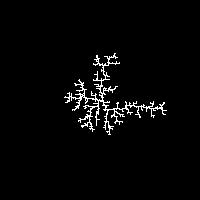

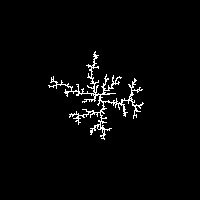

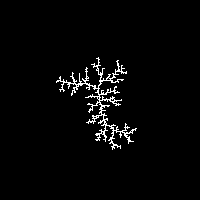

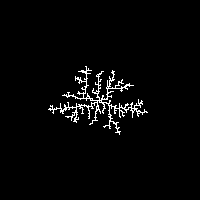

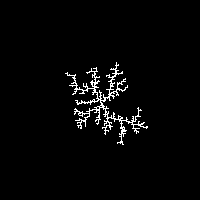

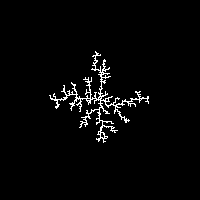

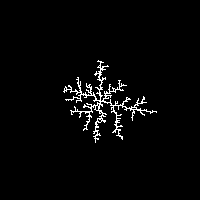

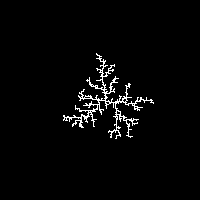

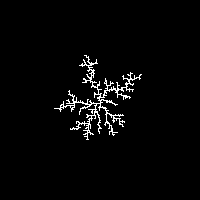

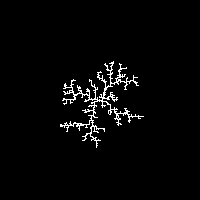

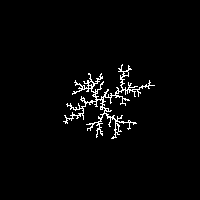

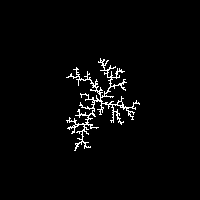

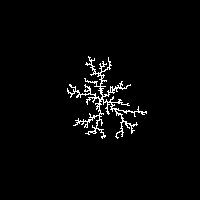

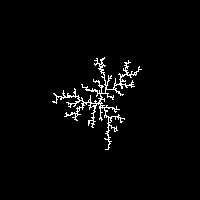

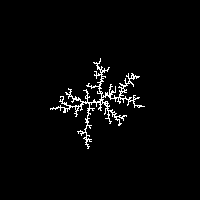

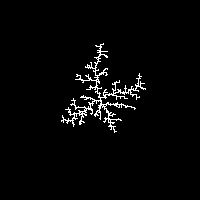

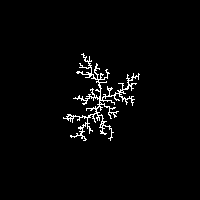

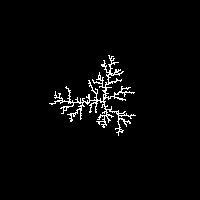

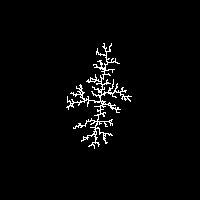

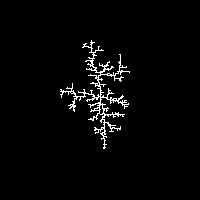

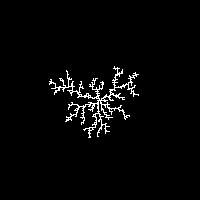

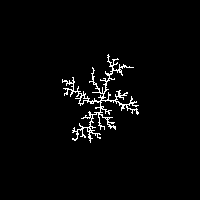

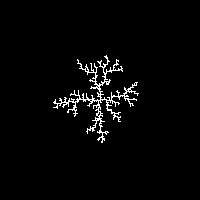

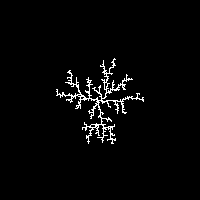

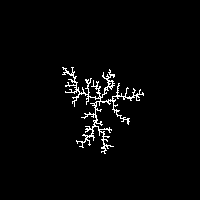

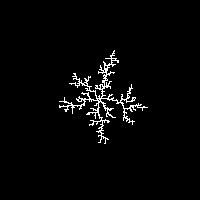

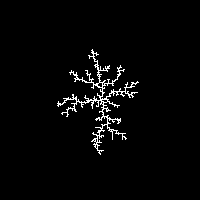

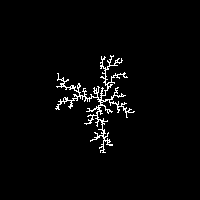

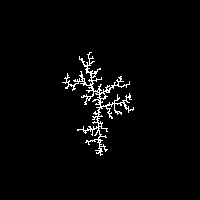

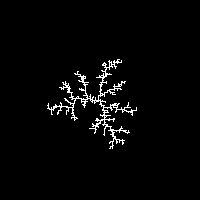

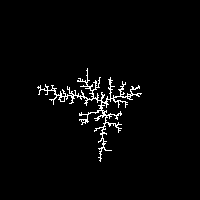

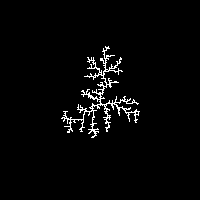

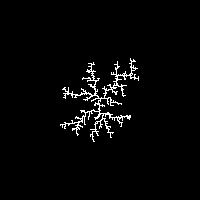

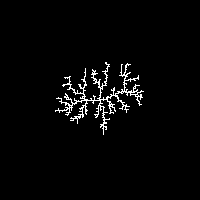

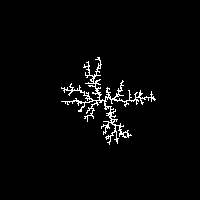

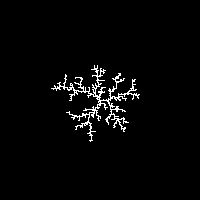

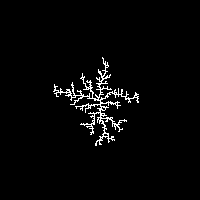

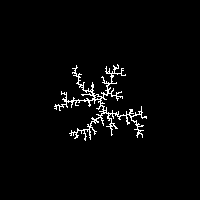

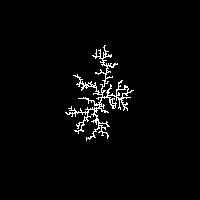

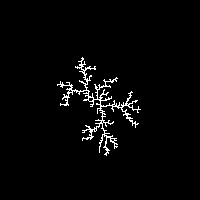

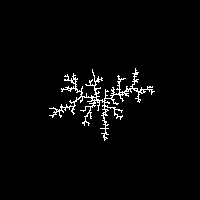

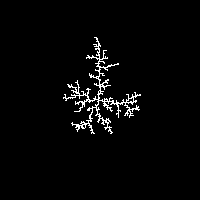

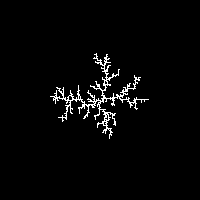

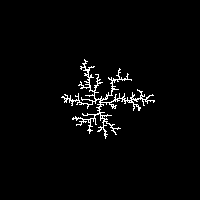

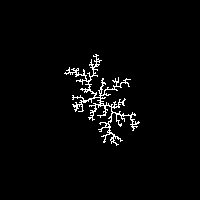

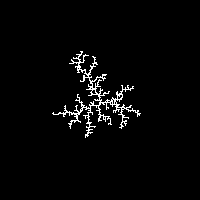

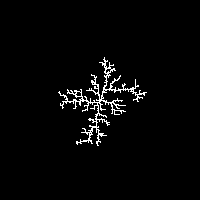

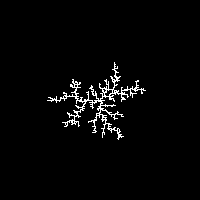

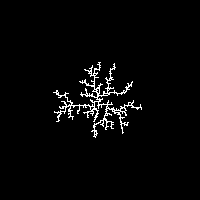

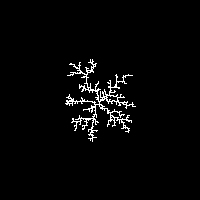

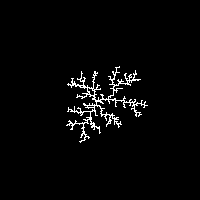

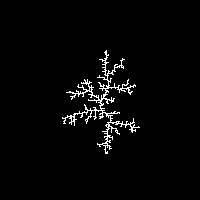

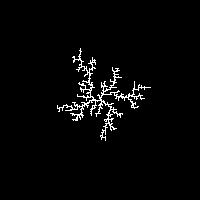

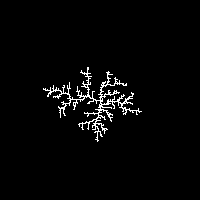

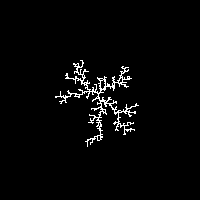

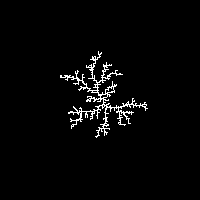

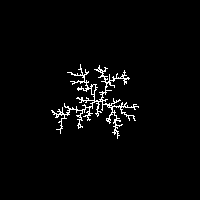

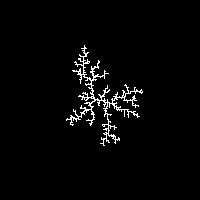

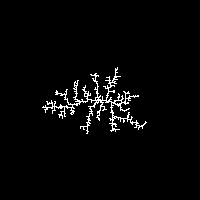

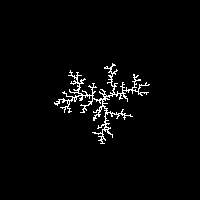

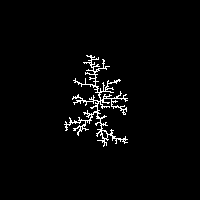

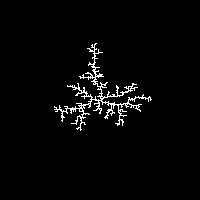

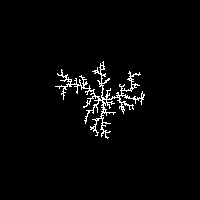

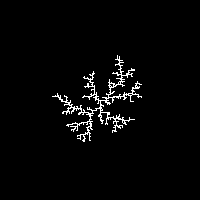

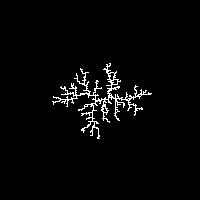

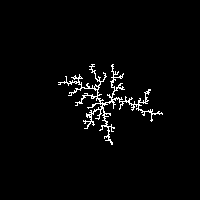

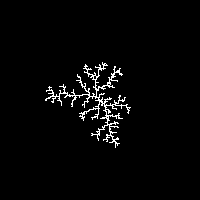

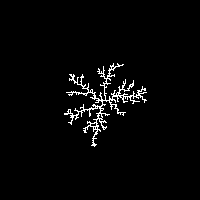

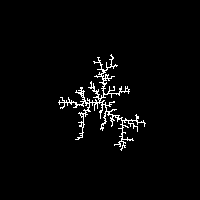

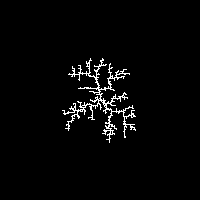

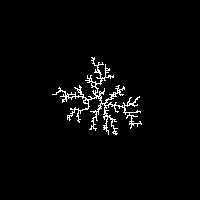

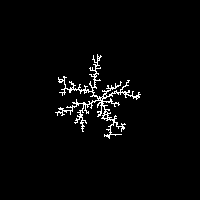

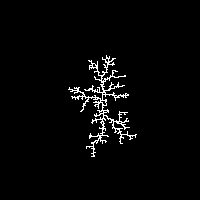

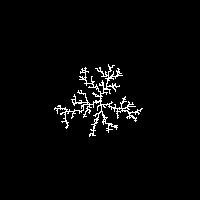

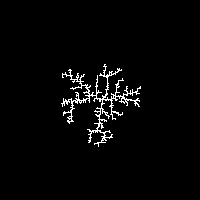

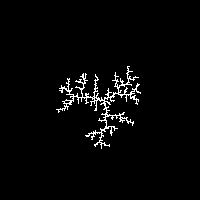

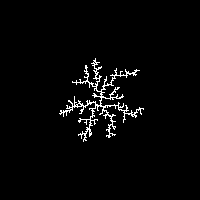

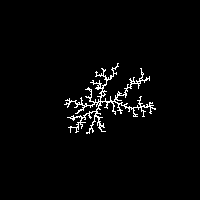

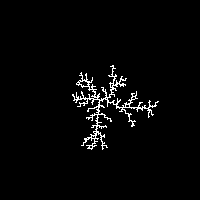

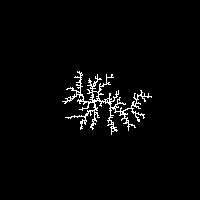

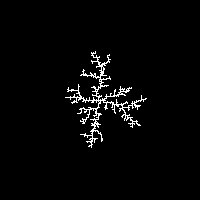

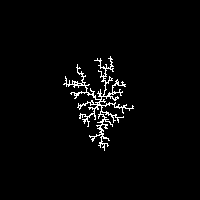

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
cnt = 0
#fig, axes = plt.subplots(1, 20, figsize=(15, 5))
ha_data = []
x = 0
for ax in range(300):
  readcsv = []
  with open(f"./drive/MyDrive/DLA_Datas/data/DLA1_{cnt}.csv","r") as f:
    reader = csv.reader(f)
    for row in reader:
      readcsv.append(list(map(int,row)))
    f.close()
  ha_data = np.array(readcsv)
  #ha_data = ha_data.astype(bool)
  size = ha_data.shape[::-1]
  databytes = np.packbits(ha_data, axis=1)
  img = Image.frombytes(mode='1', size=size, data=databytes)
  #for i in ha_data:
    #for j in i:
      #print(j*255, end = " ")
    #print("")
  display(img)
  x = np.array(img)
  img.save(f'./drive/MyDrive/DLA_Datas/img_data/output{cnt}.jpg', 'JPEG')
  #img.save("DLA1_{cnt}.jpg","JPEG")
  #ax.imshow(readcsv, cmap='gray')
  #ax.axis('off')
  cnt+=1

#plt.tight_layout()
#plt.show()

In [167]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class DLA_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_path_list = os.listdir(data_dir)
        self.transform = transforms.ToTensor()

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_path_list[index])
        x_data = Image.open(image_path)
        x_data = self.transform(x_data)

        return x_data

    def __len__(self):
        return len(self.image_path_list)

In [168]:
import torch.utils.data as data
a = DLA_Dataset(image_path)
b = DLA_Dataset(test_path)
train_dataloader = torch.utils.data.DataLoader(
            a,
            batch_size=batch_size,
            shuffle=True,

)

test_dataloader = torch.utils.data.DataLoader(
            b,
            batch_size=batch_size,
            shuffle=False,
)

In [169]:
os.makedirs(image_path, exist_ok=True)

In [170]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [171]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

In [172]:
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

In [173]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

In [174]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=lr, betas=(b1, b2)
)

In [175]:
print(encoder)

Encoder(
  (fc1): Sequential(
    (0): Linear(in_features=40000, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (mu): Linear(in_features=400, out_features=10, bias=True)
  (logvar): Linear(in_features=400, out_features=10, bias=True)
)


In [176]:
print(decoder)

Decoder(
  (fc1): Sequential(
    (0): Linear(in_features=10, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Linear(in_features=400, out_features=40000, bias=True)
)


In [177]:
for epoch in range(n_epochs):
    train_loss = 0
    for i, (x) in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i+1) % 3 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_dataloader)}], Reconst Loss : {reconst_loss.item():.4f}, KL Div: {kl_div.item():.4f}')

    print(f'===> Epoch: {epoch+1} Average Train Loss: {train_loss/len(train_dataloader.dataset):.4f} ')

    test_loss = 0
    with torch.no_grad():
        for i, (x) in enumerate(test_dataloader):
            # forward
            x = x.view(-1, img_size**2)
            x = x.to(device)
            z, mu, logvar = encoder(x)
            x_reconst = decoder(z)

            # compute reconstruction loss and KL divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

            loss = reconst_loss + kl_div
            test_loss += loss.item()

            # save reconstruction images
            if i==0:
                x_concat = torch.cat([x.view(-1, 1, 200, 200), x_reconst.view(-1, 1, 200, 200)], dim=3)
                # batch size 개수만큼의 이미지 쌍(input x, reconstructed x)이 저장됨
                save_image(x_concat, os.path.join(result_image_path,f'reconst-epoch{epoch+1}.png'))

        print(f'===> Epoch: {epoch+1} Average Test Loss: {test_loss/len(test_dataloader.dataset):.4f} ')

        # save sampled images
        z = torch.randn(batch_size, latent_dim).to(device) # N(0, 1)에서 z 샘플링
        sampled_images = decoder(z)
        save_image(sampled_images.view(-1, 1, 200, 200), os.path.join(result_image_path,f'sampled-epoch{epoch+1}.png'))

Epoch [1/30], Step [3/3], Reconst Loss : 1107053.5000, KL Div: 197.1220
===> Epoch: 1 Average Train Loss: 27114.6046 
===> Epoch: 1 Average Test Loss: 18914.7802 
Epoch [2/30], Step [3/3], Reconst Loss : 230999.7344, KL Div: 4638.2461
===> Epoch: 2 Average Train Loss: 13130.8058 
===> Epoch: 2 Average Test Loss: 4106.5717 
Epoch [3/30], Step [3/3], Reconst Loss : 146219.5938, KL Div: 4781.0308
===> Epoch: 3 Average Train Loss: 3774.3329 
===> Epoch: 3 Average Test Loss: 3410.1668 
Epoch [4/30], Step [3/3], Reconst Loss : 142117.9375, KL Div: 3784.4600
===> Epoch: 4 Average Train Loss: 3342.3483 
===> Epoch: 4 Average Test Loss: 3249.6344 
Epoch [5/30], Step [3/3], Reconst Loss : 139139.4062, KL Div: 3146.4497
===> Epoch: 5 Average Train Loss: 3242.1501 
===> Epoch: 5 Average Test Loss: 3207.1875 
Epoch [6/30], Step [3/3], Reconst Loss : 136321.9375, KL Div: 2790.0496
===> Epoch: 6 Average Train Loss: 3187.2073 
===> Epoch: 6 Average Test Loss: 3160.6767 
Epoch [7/30], Step [3/3], Recon